In [67]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# split
from sklearn.model_selection import StratifiedShuffleSplit

# from spam
from collections import Counter

# word embedding
from gensim.models import Word2Vec
import multiprocessing

# count vectorizer
from sklearn.feature_extraction.text import CountVectorizer

# keras
from keras.preprocessing import sequence
from keras.models import Model, load_model
from keras.layers.merge import concatenate
from keras.layers import Dense, GlobalMaxPooling1D, Activation, Dropout, Embedding, Input, Conv1D
from keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping

# score
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix, roc_auc_score, classification_report

In [2]:
data = pd.read_csv('../X_train.csv')

In [3]:
data.dropna(inplace = True)

In [18]:
sentences = list(data['tokenized_text'].apply(lambda x: x.split(' ')))

### Train a word embedding using CBOW

In [20]:
EMBED_DIM = 300
emb = Word2Vec(sentences, size=EMBED_DIM, window=3, 
               min_count=3, negative=15, iter=1, 
               workers=multiprocessing.cpu_count())
# get the word vector
word_vec = emb.wv

KeyboardInterrupt: 

In [ ]:
print(emb)

In [ ]:
emb.save('../CBOW300.bin')

In [3]:
# load model
new_model = Word2Vec.load('../CBOW300.bin')
print(new_model)

Word2Vec(vocab=95581, size=300, alpha=0.025)


In [ ]:
EMBED_DIMS = [200, 400, 600, 800, 1000]
for dim in EMBED_DIMS:
    emb = Word2Vec(sentences, size=dim, window=3, 
                   min_count=3, negative=15, iter=1, 
                   workers=multiprocessing.cpu_count())
    emb.save(f'../CBOW{dim}.bin')

### Train word embedding using skip-gram

In [73]:
EMBED_DIM = 300
emb = Word2Vec(sentences, size=EMBED_DIM, window=3, 
               min_count=3, negative=15, iter=1, sg=1, 
               workers=multiprocessing.cpu_count())
# get the word vector
word_vec = emb.wv

In [ ]:
print(emb)

In [74]:
emb.save('../SKIP-GRAM300.bin')

In [4]:
# load model
new_model_2 = Word2Vec.load('../CBOW300.bin')
print(new_model_2)

Word2Vec(vocab=95581, size=300, alpha=0.025)


### Split the train to train and dev

In [5]:
y = pd.DataFrame(data['mental_state'])
X = data[['tokenized_text']].copy()

In [6]:
X.reset_index(inplace = True)
y.reset_index(inplace = True)

In [7]:
X.drop(labels='index', axis=1, inplace = True)
y.drop(labels='index', axis=1, inplace = True)

Source: https://www.kaggle.com/danielsafai/cnn-implementation-of-yoon-kim-s-model

In [8]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
sss.get_n_splits(X, y)
for train_index, test_index in sss.split(X, y):
    X_train, X_dev = X.loc[train_index, :], X.loc[test_index, :]
    y_train, y_dev = y.loc[train_index], y.loc[test_index]

### Performance Template

In [53]:
def performance(y_true, y_hat, model):
    
    y_true = list(map(lambda x: np.argmax(x), y_true))
    y_hat = list(map(lambda x: np.argmax(x), y_hat))
    
    y_true_roc = pd.DataFrame(y_true, columns = ['mental_state'])
    y_hat_roc = pd.DataFrame(y_hat, columns = ['mental_state'])
    
    y_true_roc = pd.get_dummies(y_true_roc['mental_state']).values
    y_hat_roc = pd.get_dummies(y_hat_roc['mental_state']).values
    
    # result template
    print('-'*40+' Result Report '+'-'*40)
    
    # Accuracy
    print('Accuracy: ', accuracy_score(y_true,y_hat))
    
    # Confusion matrix
    print('\n')
    print('Confusion Matrix: \n', confusion_matrix(y_true,y_hat))
    print('\n')

    # Classification Report
    print('Classification Report: \n')
    print(classification_report(y_true, y_hat))
    print('\n')
    
    # Aggregated area under the ROC curve
    print('Area under ROC curve: ', roc_auc_score(y_true_roc, y_hat_roc, multi_class='ovo'))
    
    print('-'*95)


### Train Preparation

In [10]:
#CBOW
word_vec = new_model.wv
#SKIP GRAM
word_vec_2 = new_model_2.wv

In [10]:
list_X_train = list(X_train['tokenized_text'].values)
list_X_dev = list(X_dev['tokenized_text'].values)

In [11]:
# set the parameters
EMBED_SIZE = 300
#MAX_WORDS = 85971
#MAX_WORDS_IN_SENT = 4640
SET_LIMIT_SENTENCE = 150

t = Tokenizer()
t.fit_on_texts(list_X_train)
vocab_size = len(t.word_index) + 1

list_tokenized_train = t.texts_to_sequences(list_X_train)
list_tokenized_test = t.texts_to_sequences(list_X_dev)

In [12]:
X_train_pad = pad_sequences(list_tokenized_train, maxlen=SET_LIMIT_SENTENCE, padding='post')
X_test_pad = pad_sequences(list_tokenized_test, maxlen=SET_LIMIT_SENTENCE, padding='post')

In [13]:
# get the dummy for y values
y = pd.get_dummies(y_train['mental_state']).values
y_test = pd.get_dummies(y_dev['mental_state']).values

In [65]:
sliced_X_train_pad = np.concatenate((X_train_pad[:10000], X_train_pad[-10000:]))
sliced_y = np.concatenate((y[:10000], y[-10000:]))

### Open Glove 

In [15]:
import zipfile
with zipfile.ZipFile('../glove.42B.300d.zip', 'r') as zip_ref:
    zip_ref.extractall('../glove.42B.300d.txt')

In [16]:
embedding_vector = {}
f = open('../glove.42B.300d.txt/glove.42B.300d.txt')

# get the mapping words and coefficient here
for line in tqdm(f):
    value = line.split(' ')
    word = value[0]
    coef = np.array(value[1:],dtype = 'float32')
    embedding_vector[word] = coef

# create the embedding matrix
embedding_matrix = np.zeros((vocab_size,300))
# check if the word exist in tokenizer
for word,i in tqdm(t.word_index.items()):
    embedding_value = embedding_vector.get(word)
    # some words may not exist in Glove
    if embedding_value is not None:
        embedding_matrix[i] = embedding_value

1917495it [03:14, 9875.59it/s] 
100%|██████████| 242825/242825 [00:00<00:00, 390407.07it/s]


### This is for CBOW and Skip-gram

In [17]:
# create a weight matrix for the Embedding layer from a loaded embedding
def get_weight_matrix(embedding, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, 300))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        try:
            weight_matrix[i] = embedding[word]
        except:
            pass
    return weight_matrix

# get vectors in the right order
embedding_vectors = get_weight_matrix(word_vec, t.word_index)
embedding_vectors_2 = get_weight_matrix(word_vec_2, t.word_index)

### Design the CNN Non-Static Kim Yoon

In [22]:
inp = Input(shape=(X_train_pad.shape[1],), dtype='int64')

# set the embedding layer (use Glove)
emb = Embedding(vocab_size, EMBED_SIZE, weights=[embedding_matrix], trainable=False)(inp)
conv_filters = 100

# Specify each convolution layer and their kernel size i.e. n-grams 
conv1_1 = Conv1D(filters=conv_filters, kernel_size=3, activation='relu')(emb)
glmp1_1 = GlobalMaxPooling1D()(conv1_1)

conv1_2 = Conv1D(filters=conv_filters, kernel_size=4, activation='relu')(emb)
glmp1_2 = GlobalMaxPooling1D()(conv1_2)

conv1_3 = Conv1D(filters=conv_filters, kernel_size=5, activation='relu')(emb)
glmp1_3 = GlobalMaxPooling1D()(conv1_3)

# Gather all convolution layers
cnct = concatenate([glmp1_1, glmp1_2, glmp1_3], axis=1)
drp1 = Dropout(0.5)(cnct)

# softmax
out = Dense(y.shape[1], activation='softmax', kernel_regularizer='l2')(drp1)

In [23]:
model_1 = Model(inputs=inp, outputs=out)
model_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_1.summary())

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 150)          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 150, 300)     72847800    input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 148, 100)     90100       embedding_2[0][0]                
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 147, 100)     120100      embedding_2[0][0]                
____________________________________________________________________________________________

In [81]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
history_1 = model_1.fit(X_train_pad, y, validation_data=(X_test_pad, y_test), verbose=1, 
                        epochs=10, batch_size=50, shuffle=True, callbacks=[es])


Train on 1319109 samples, validate on 146568 samples
Epoch 1/10
 762500/1319109 [================>.............] - ETA: 16:43 - loss: 0.5735 - accuracy: 0.7545

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1319109/1319109 [==============================] - 2465s 2ms/step - loss: 0.5756 - accuracy: 0.7533 - val_loss: 0.5511 - val_accuracy: 0.7621
Epoch 2/10
 749100/1319109 [================>.............] - ETA: 17:17 - loss: 0.5722 - accuracy: 0.7546

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1062150/1319109 [=======================>......] - ETA: 7:40 - loss: 0.5728 - accuracy: 0.7543

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1319109/1319109 [==============================] - 2431s 2ms/step - loss: 0.5736 - accuracy: 0.7541 - val_loss: 0.5475 - val_accuracy: 0.7695
Epoch 3/10
  44200/1319109 [>.............................] - ETA: 36:29 - loss: 0.5655 - accuracy: 0.7603

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 360750/1319109 [=======>......................] - ETA: 27:48 - loss: 0.5662 - accuracy: 0.7579

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 668900/1319109 [==============>...............] - ETA: 19:08 - loss: 0.5677 - accuracy: 0.7571

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 537600/1319109 [===========>..................] - ETA: 23:30 - loss: 0.5656 - accuracy: 0.7577

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1319109/1319109 [==============================] - 2479s 2ms/step - loss: 0.5680 - accuracy: 0.7567 - val_loss: 0.5437 - val_accuracy: 0.7692
Epoch 5/10
1319109/1319109 [==============================] - 2485s 2ms/step - loss: 0.5656 - accuracy: 0.7581 - val_loss: 0.5496 - val_accuracy: 0.7672
Epoch 6/10
1232800/1319109 [===========================>..] - ETA: 2:39 - loss: 0.5637 - accuracy: 0.7592

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



### Plot the history result to check for overfit

10 epoch all training data with early stopping

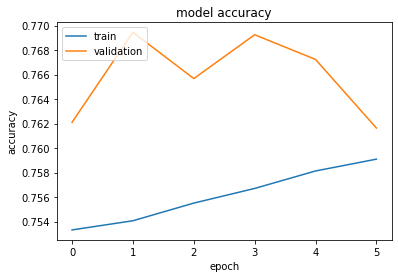

In [82]:
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

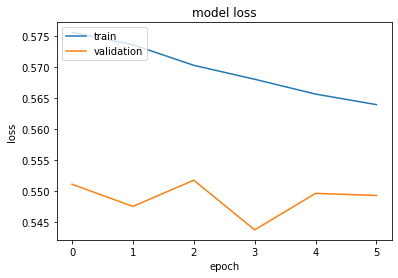

In [83]:
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

10 epoch 100000 sample size

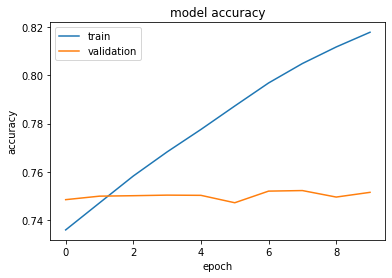

In [71]:
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

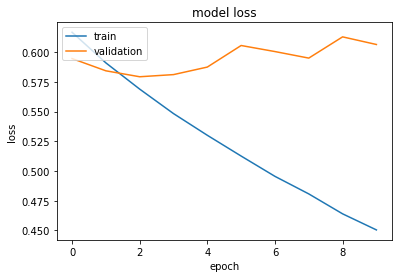

In [72]:
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Result

Predict model on test set

In [34]:
# get the test data on twitter
data_test = pd.read_csv('../X_test.csv')
data_test.dropna(inplace = True)
data_test.reset_index(inplace = True)
data_test.drop(labels='index', axis=1, inplace = True)

In [35]:
list_X_twit_test = list(data_test['tokenized_text'].values)
list_tokenized_twit_test = t.texts_to_sequences(list_X_twit_test)
X_twit_test = pad_sequences(list_tokenized_twit_test, maxlen=SET_LIMIT_SENTENCE, padding='post')

In [37]:
y_twit_test =  pd.get_dummies(data_test['mental_state']).values

10 epoch all training data with early stopping

In [84]:
y_hat_twit = model_1.predict(X_twit_test)
performance(y_twit_test, y_hat_twit)

---------------------------------------- Result Report ----------------------------------------
Accuracy:  0.7597112681821904


Confusion Matrix: 
 [[ 98020   9178    764]
 [ 13930 140709  13486]
 [  7780  42911  39652]]


Classification Report: 

              precision    recall  f1-score   support

           0       0.82      0.91      0.86    107962
           1       0.73      0.84      0.78    168125
           2       0.74      0.44      0.55     90343

    accuracy                           0.76    366430
   macro avg       0.76      0.73      0.73    366430
weighted avg       0.76      0.76      0.75    366430



Area under ROC curve:  0.79757795550577
-----------------------------------------------------------------------------------------------


10 epoch 100000 sample size

In [58]:
y_hat_twit = model_1.predict(X_twit_test)

In [59]:
performance(y_twit_test, y_hat_twit)

---------------------------------------- Result Report ----------------------------------------
Accuracy:  0.7497884998499031


Confusion Matrix: 
 [[ 95255  10717   1990]
 [ 14172 129489  24464]
 [  7232  33110  50001]]


Classification Report: 

              precision    recall  f1-score   support

           0       0.82      0.88      0.85    107962
           1       0.75      0.77      0.76    168125
           2       0.65      0.55      0.60     90343

    accuracy                           0.75    366430
   macro avg       0.74      0.74      0.74    366430
weighted avg       0.74      0.75      0.75    366430



Area under ROC curve:  0.8010527773082217
-----------------------------------------------------------------------------------------------


In [85]:
# save model and architecture to single file
model_1.save("model_cnn_static_full.h5")

In [64]:
# load model
model = load_model('model_cnn_static.h5')
# summarize model.
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 150)          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 150, 300)     72847800    input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 148, 100)     90100       embedding_2[0][0]                
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 147, 100)     120100      embedding_2[0][0]                
____________________________________________________________________________________________

In [100]:
def check_mental_state(model, post, tokenizer):
    
    dic_state = {0:'Normal', 1:'Depressed', 2:'Suicidal'}
    
    SET_LIMIT_SENTENCE = 150
    
    print('Post: \n')
    print(post)
    print('\n')
    
    list_post = [post]
    list_post_tokenized = tokenizer.texts_to_sequences(list_post)
    post_pad = pad_sequences(list_post_tokenized, maxlen=SET_LIMIT_SENTENCE, padding='post')
    
    # classify mental state
    mental_state = model.predict(post_pad)
    
    print('Normal: ', str(round(mental_state[0][0], 2)*100)+'%')
    print('Depressed: ', str(round(mental_state[0][1], 2)*100)+'%')
    print('Suicidal: ', str(round(mental_state[0][2], 2)*100)+'%')
    
    classify_state = np.argmax(mental_state[0])
    #list(map(lambda x: np.argmax(x), mental_state))
    
    print('\n')
    print('Model Classify: ', dic_state[classify_state])
    

### Post test

In [101]:
post = data_test[data_test['mental_state']==2]['tokenized_text'][19]
check_mental_state(model_1, post, t)

Post: 

i know i tried everything guys i gone different psychologists types anti depressants i made effort get bed every day walk my dog go gym read distant feeling increases exponentially day i never really loved life i loved people it lately spark disappeared i connect anyone fine i even connect my parents kills me inside i want stop mundane cycle my life become initially i told myself i stick it them i longer hold restrictions i always tried my best persevere keep looking forward i cried day today i realized threshold kept me taking action disappeared i want it feel selfish even thoughts somewhere i smiled loved i feel outcome inevitable please help


Normal:  0.0%
Depressed:  82.99999833106995%
Suicidal:  17.000000178813934%


Model Classify:  Depressed


In [103]:
post = data_test[data_test['mental_state']==1]['tokenized_text'][366423]
check_mental_state(model_1, post, t)

Post: 

i suicidal thoughts first time i suicidal thoughts i able speak my problems end my parents finally took me psychologist they always said i lazy lot sad things happened my grandfather passed away i terribly low i feeling hopeful barely suicidal thoughts still confidence months back my parents started arguing lot leading divorce my mom lied much got me stressed point i ca sleep night i also started going gym improve my i feel tired i think i give warning might trigger i tried commit suicide times never told my parents mostly tried hanging myself i always wanted die quickly last night i tried cut myself never thought i would i scared i might myself my psychologist vacation i feel guilty make my parents waste money me i think i deserve it i getting distant my friends i want hurt them i kill myself i trying keep my mind busy arguing making me stressed every day it seems like one end me amp amp


Normal:  0.0%
Depressed:  46.99999988079071%
Suicidal:  52.99999713897705%


Model Class

In [110]:
post = data_test[data_test['mental_state']==0]['tokenized_text'][2]
check_mental_state(model_1, post, t)

Post: 

cc room get enough love time day come play some music hang cc room great way find new music chatting lovely people we got people room we would love come party us follow link https hit headphones sidebar go room you need sign you account already it quick easy


Normal:  100.0%
Depressed:  0.0%
Suicidal:  0.0%


Model Classify:  Normal


### Design the CNN Multi Channel Kim Yoon (for future studies only, not inlcuded in the paper)

In [54]:
conv_filters = 100

In [55]:
####################### Channel ONE ##################################
# channel 1 (CBOW)
inputs1 = Input(shape=(X_train_pad.shape[1],))
embedding1 = Embedding(vocab_size, EMBED_SIZE, weights=[embedding_vectors])(inputs1)
conv1_1 = Conv1D(filters=conv_filters, kernel_size=3, activation='relu')(embedding1)
drop1_1 = Dropout(0.5)(conv1_1)
glmp1_1 = GlobalMaxPooling1D()(drop1_1)

conv1_2 = Conv1D(filters=conv_filters, kernel_size=4, activation='relu')(embedding1)
drop1_2 = Dropout(0.5)(conv1_2)
glmp1_2 = GlobalMaxPooling1D()(drop1_2)

conv1_3 = Conv1D(filters=conv_filters, kernel_size=5, activation='relu')(embedding1)
drop1_3 = Dropout(0.5)(conv1_3)
glmp1_3 = GlobalMaxPooling1D()(drop1_3)

# Gather all convolution layers
cnct_1 = concatenate([glmp1_1, glmp1_2, glmp1_3], axis=1)
drp1 = Dropout(0.5)(cnct_1)

####################### Channel TWO ##################################
# channel 2 (SKIP-GRAM)
inputs2 = Input(shape=(X_train_pad.shape[1],))
embedding2 = Embedding(vocab_size, EMBED_SIZE, weights=[embedding_vectors_2])(inputs2)
conv2_1 = Conv1D(filters=conv_filters, kernel_size=3, activation='relu')(embedding2)
drop2_1 = Dropout(0.5)(conv2_1)
glmp2_1 = GlobalMaxPooling1D()(drop2_1)

conv2_2 = Conv1D(filters=conv_filters, kernel_size=4, activation='relu')(embedding2)
drop2_2 = Dropout(0.5)(conv2_2)
glmp2_2 = GlobalMaxPooling1D()(drop2_2)

conv2_3 = Conv1D(filters=conv_filters, kernel_size=5, activation='relu')(embedding2)
drop2_3 = Dropout(0.5)(conv2_3)
glmp2_3 = GlobalMaxPooling1D()(drop2_3)

# Gather all convolution layers
cnct_2 = concatenate([glmp2_1, glmp2_2, glmp2_3], axis=1)
drp2 = Dropout(0.5)(cnct_2)

#################### Combine both channel ##############################
# merge
merged = concatenate([drp1, drp2])

# interpretation
#dense1 = Dense(100, activation='relu')(merged)
drp_last  = Dropout(0.2)(merged)
outputs = Dense(y.shape[1], activation='softmax', kernel_regularizer='l2')(drp_last)

NameError: name 'embedding_vectors' is not defined

In [56]:
model_2 = Model(inputs=[inputs1, inputs2], outputs=outputs)
model_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_2.summary())

NameError: name 'inputs2' is not defined

In [ ]:
history_2 = model_2.fit([sliced_X_train_pad,sliced_X_train_pad] , sliced_y, 
                        validation_data=([X_test_pad, X_test_pad], y_test), verbose=1, 
                        epochs=1, batch_size=64, shuffle=True)

### Result

Predict on extra validation set

In [ ]:
y_hat = model_2.predict(X_test_pad)
performance(y_test, y_hat)

Predict on test dataset

In [ ]:
y_hat_twit = model_1.predict(X_twit_test)
performance(y_twit_test, y_hat_twit)